In [0]:
# Load necessary packages

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

In [2]:
uploaded = files.upload()

NameError: ignored

In [5]:
# Read data and present

train = pd.read_csv('trainingData.csv')
valid = pd.read_csv('validationData.csv')
train.head()

,deck,nofGames,nOfPlayers,winRate
0,archers;arrows;baby-dragon;balloon;bats;fireba...,44,2,0.58511
1,archers;arrows;baby-dragon;balloon;bomber;free...,143,3,0.53767
2,archers;arrows;baby-dragon;balloon;bomber;gian...,61,3,0.34375
3,archers;arrows;baby-dragon;balloon;cannon;free...,162,1,0.49394
4,archers;arrows;baby-dragon;balloon;electro-wiz...,57,1,0.55833


In [0]:
valid.head()

,deck,nofGames,nOfPlayers,winRate
0,archers;arrows;baby-dragon;bandit;elixir-colle...,130,32,0.48496
1,archers;arrows;baby-dragon;elixir-collector;go...,495,75,0.47289
2,archers;arrows;baby-dragon;golem;lightning;meg...,271,25,0.52372
3,archers;arrows;baby-dragon;golem;lightning;meg...,125,20,0.58594
4,archers;arrows;balloon;barbarians;fireball;gia...,130,23,0.50000


In [0]:
# Helper functions to preprocess data to bag-of-cards format

def unnest(df, col):
    unnested = (df.apply(lambda x: pd.Series(x[col]), axis=1)
                .stack()
                .reset_index(level=1, drop=True))
    unnested.name = col
    return df.drop(col, axis=1).join(unnested)

def to_bag_of_cards(df):
    df['ind'] = np.arange(df.shape[0]) + 1
    df_orig = df.copy()
    df['deck'] = df['deck'].apply(lambda d: d.split(';'))
    df = unnest(df, 'deck')
    df['value'] = 1
    df_bag = df.pivot(index='ind', columns='deck', values='value')
    df_bag[df_bag.isna()] = 0
    df_bag = df_bag.astype('int')
    return pd.concat([df_orig.set_index('ind'), df_bag], axis=1)

In [7]:
train = to_bag_of_cards(train)
valid = to_bag_of_cards(valid)
train.head()

,deck,nofGames,nOfPlayers,winRate,archers,arrows,baby-dragon,balloon,bandit,barbarian-barrel,barbarian-hut,barbarians,bats,battle-ram,bomb-tower,bomber,bowler,cannon,cannon-cart,clone,dark-prince,dart-goblin,electro-dragon,electro-wizard,elite-barbarians,elixir-collector,executioner,fire-spirits,fireball,flying-machine,freeze,furnace,giant,giant-skeleton,giant-snowball,goblin-barrel,goblin-gang,goblin-giant,goblin-hut,goblins,...,lumberjack,magic-archer,mega-knight,mega-minion,miner,mini-pekka,minion-horde,minions,mirror,mortar,musketeer,night-witch,pekka,poison,prince,princess,rage,ram-rider,rascals,rocket,royal-ghost,royal-giant,royal-hogs,royal-recruits,skeleton-army,skeleton-barrel,skeletons,sparky,spear-goblins,tesla,the-log,three-musketeers,tombstone,tornado,valkyrie,witch,wizard,x-bow,zap,zappies
ind,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,archers;arrows;baby-dragon;balloon;bats;fireba...,44,2,0.58511,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,archers;arrows;baby-dragon;balloon;bomber;free...,143,3,0.53767,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,archers;arrows;baby-dragon;balloon;bomber;gian...,61,3,0.34375,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,archers;arrows;baby-dragon;balloon;cannon;free...,162,1,0.49394,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,archers;arrows;baby-dragon;balloon;electro-wiz...,57,1,0.55833,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [0]:
valid.head()

,deck,nofGames,nOfPlayers,winRate,archers,arrows,baby-dragon,balloon,bandit,barbarian-barrel,...,the-log,three-musketeers,tombstone,tornado,valkyrie,witch,wizard,x-bow,zap,zappies
ind,,,,,,,,,,,,,,,,,,,,,
1,archers;arrows;baby-dragon;bandit;elixir-colle...,130,32,0.48496,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,archers;arrows;baby-dragon;elixir-collector;go...,495,75,0.47289,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,archers;arrows;baby-dragon;golem;lightning;meg...,271,25,0.52372,1,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,archers;arrows;baby-dragon;golem;lightning;meg...,125,20,0.58594,1,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,archers;arrows;balloon;barbarians;fireball;gia...,130,23,0.50000,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [0]:
# Sort data by number of games played

train = train.sort_values('nofGames', ascending=False)
valid = valid.sort_values('nofGames', ascending=False)

In [0]:
# Specify example model fitting function and R squared metric

from sklearn.svm import SVR

def R2(x, y):
    return 1 - np.sum(np.square(x - y)) / np.sum(np.square(y - np.mean(y)))

def fit_svm(data):
    svr = SVR(kernel='rbf', gamma=1.0/90, C=1.0, epsilon=0.02, shrinking=False)
    svr.fit(data.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), data['winRate'])
    return svr

sizes = (np.arange(10) + 6) * 100

In [0]:
# Fit and predict on models of various training sizes

fit_list = list(map(lambda size: fit_svm(train.iloc[:size]), sizes))
pred_list = list(map(lambda fit: fit.predict(valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1)),
                     fit_list))

In [14]:
from sklearn.svm import NuSVR

nuSVM = NuSVR(kernel='rbf', gamma=1.0/90, C=1.0, nu=0.01, shrinking=False)
nuSVM.fit(train.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train['winRate'], sample_weight=train['nofGames']/np.max(train['nofGames']))
preds = nuSVM.predict(valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1))
print(R2(preds, valid['winRate']))
print(len(nuSVM.support_))

train2 = train.loc[nuSVM.support_]
nuSVM2 = NuSVR(kernel='rbf', gamma=1.0/90, C=1.0, nu=0.01, shrinking=False)
nuSVM2.fit(train2.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1), train2['winRate'], sample_weight=train2['nofGames']/np.max(train2['nofGames']))
preds2 = nuSVM2.predict(valid.drop(['deck', 'nofGames', 'nOfPlayers', 'winRate'], axis=1))
print(R2(preds2, valid['winRate']))
print(len(nuSVM2.support_))

-0.10182531680994567
5303
-15.922072393025385
145


In [12]:
np.max(train['nofGames']/np.max(train['nofGames']))


1.0

In [0]:
# Calculate R squared scores

r2 = list(map(lambda p: R2(p, valid['winRate']), pred_list))
r2

[0.10344987362711122,
 0.08405282267430436,
 0.07045797619640926,
 0.06580580356586674,
 0.07666856402385402,
 0.09148645985837811,
 0.08444265882025248,
 0.09842188384239492,
 0.10762443890113671,
 0.12183633485005685]

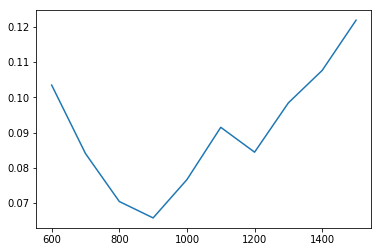

In [0]:
_ = plt.plot(sizes, r2)

In [0]:
np.mean(r2)

0.09042468163597647

In [0]:
# Save hyperparameteres and selected indices in submission format

with open('example_sub_python.txt', 'a') as f:
    for size in sizes:
        ind_text = ','.join(list(map(str, train.index.values[:size])))
        text = ';'.join(['0.02', '1.0', str(1.0 / 90), ind_text])
        f.write(text + '\n')